DAOGroup takes a group of stars and gives them a label which identifies them as part of a group 

https://photutils.readthedocs.io/en/stable/grouping.html
https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOGroup.html#photutils.psf.DAOGroup

In [1]:
# STUFF FOR PLOTTING AND ECLIPSE IMAGE INFO
# for images too (also will use mpl)

# %matplotlib notebook
import numpy as np

import fitsio
from astropy.io import fits
#import sys 
import numpy.ma as ma
from gPhoton.reference import eclipse_to_paths
from gPhoton.coadd import zero_flag_and_edge

import pandas as pd 

# info 
eclipse, band, depth, compression = 35688, "NUV", 30, "rice"

galex_file_paths = eclipse_to_paths(
    eclipse, '/home/bekah/gphoton_working/test_data', depth, compression
)

sources = pd.read_csv("35688_sources_0th_r1_5px.csv")


# image to hdul 
%time hdul = fitsio.FITS(galex_file_paths[band]['image'])
%time cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]

# masking cnt image
masked_cnt = zero_flag_and_edge(cnt, flag, edge)


# clipping 
def centile_clip(image, centiles=(1, 99)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

CPU times: user 341 µs, sys: 130 µs, total: 471 µs
Wall time: 476 µs
CPU times: user 195 ms, sys: 47.8 ms, total: 242 ms
Wall time: 241 ms


In [2]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

from astropy.table import QTable, Table, Column 

starlist = Table()

x_0 = list(zip(*positions))[0]
y_0 = list(zip(*positions))[1]

starlist['x_0'] = x_0
starlist['y_0'] = y_0

In [3]:
starlist

x_0,y_0
float64,float64
1435.9077410601508,112.62518995746925
1656.5200708438929,122.81674845320862
1433.4970498663954,126.43035793821
1766.5946664738146,127.09972601521248
1474.5024747747648,127.89214939925124
1544.1364382194324,131.65240908516498
...,...
1560.1139626953614,3098.0173587145923
1779.4470184170837,3102.563763461972


In [38]:
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.psf.groupstars import DAOGroup

fwhm = 9 # sigma_psf * gaussian_sigma_to_fwhm
%time daogroup = DAOGroup(crit_separation=2.5 * fwhm)

CPU times: user 57 µs, sys: 2 µs, total: 59 µs
Wall time: 71.8 µs


In [37]:
%time star_groups = daogroup(starlist)

# https://docs.astropy.org/en/stable/table/pandas.html
star_groups_pd = star_groups.to_pandas().groupby(['group_id'])

star_groups = star_groups.group_by('group_id')
 
star_groups_count = star_groups_pd.size()

star_groups_count.sort_values(ascending=False)


CPU times: user 1.26 s, sys: 11 µs, total: 1.26 s
Wall time: 1.26 s


group_id
1620    176
1651     38
1168     17
834      15
1295     13
       ... 
824       1
823       1
822       1
820       1
2158      1
Length: 2158, dtype: int64

In [41]:
from photutils.psf.groupstars import DBSCANGroup

fwhm_db = 12

%time dbscan_group = DBSCANGroup(crit_separation=2.5 * fwhm_db)

%time dbsc_star_groups = dbscan_group(starlist)

dbsc_star_groups_pd = dbsc_star_groups.to_pandas().groupby(['group_id'])

dbsc_star_groups = dbsc_star_groups.group_by('group_id')
 
dbsc_star_groups_count = dbsc_star_groups_pd.size()

dbsc_star_groups_count.sort_values(ascending=False)

CPU times: user 25 µs, sys: 1 µs, total: 26 µs
Wall time: 36.7 µs
CPU times: user 24.8 ms, sys: 25 µs, total: 24.8 ms
Wall time: 23.5 ms


group_id
1107    260
1196     45
859      17
609      17
953      16
       ... 
916       1
919       1
921       1
922       1
1542      1
Length: 1542, dtype: int64

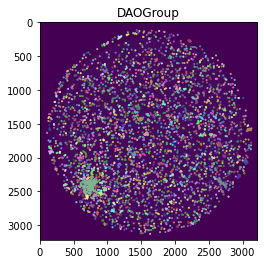

In [7]:
import numpy as np
from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
import matplotlib as mpl
import matplotlib.pyplot as plt

# DAOGroup 

plt.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')

cmap = make_random_cmap(ncolors=4000,seed=123)
for i, group in enumerate(star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CircularAperture(xypos, r=fwhm)
    ap.plot(color=cmap.colors[i],lw=.8)
plt.title('DAOGroup')
plt.show()

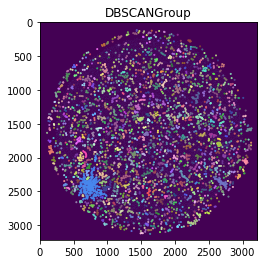

In [42]:
# DBSCAN 

plt.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')

cmap = make_random_cmap(ncolors=4000,seed=123)
for i, group in enumerate(dbsc_star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CircularAperture(xypos, r=fwhm)
    ap.plot(color=cmap.colors[i],lw=.8)
plt.title('DBSCANGroup')
plt.show()

In [9]:
# Trying to fit an ellipse to the points 

import numpy as np
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

extended_dict = [] 

for i, group in enumerate(star_groups.groups):
    if len(group) > 20: 
        xypos = np.transpose([group['x_0'], group['y_0']])

        ell = EllipseModel()

        ell.estimate(xypos)
        print(np.mean(ell.residuals(xypos)))
        xc, yc, a, b, theta = ell.params
        extended_dict.append({'xc':xc, 'yc':yc, 'a':a+np.mean(ell.residuals(xypos)), 'b':b+np.mean(ell.residuals(xypos)), 'theta':theta})

        print("center = ",  (xc, yc))
        print("angle of rotation = ",  theta)
        print("axes = ", (a,b))
        
extended_sources = pd.DataFrame.from_dict(extended_dict)

31.85885123544156
center =  (731.5882348815982, 2417.154707008062)
angle of rotation =  1.2465937799924793
axes =  (84.34643227178891, 90.22154427634439)
12.802668944921948
center =  (2699.5812004351133, 2368.021681383313)
angle of rotation =  0.7081720304683409
axes =  (61.36881987947708, 24.53306078086663)


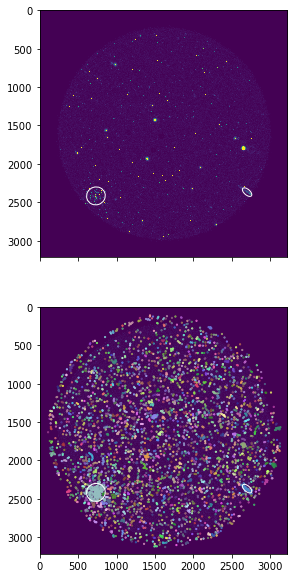

In [10]:

fig, axs = plt.subplots(2, 1,  figsize = (8, 10), sharex=True, sharey=True)

axs[0].imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')

for i in range(len(extended_sources)):
    ell_patch = Ellipse((extended_sources.loc[i,'xc'], extended_sources.loc[i,'yc']), 2*extended_sources.loc[i,'a'], 2*extended_sources.loc[i,'b'], extended_sources.loc[i,'theta']*180/np.pi, edgecolor='white', facecolor='none')
    axs[0].add_patch(ell_patch)
    
axs[1].imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
cmap = make_random_cmap(ncolors=4000,seed=34)

for i, group in enumerate(star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CircularAperture(xypos, r=fwhm)
    ap.plot(color=cmap.colors[i],lw=.8)
    
for i in range(len(extended_sources)):
    ell_patch = Ellipse((extended_sources.loc[i,'xc'], extended_sources.loc[i,'yc']), 2*extended_sources.loc[i,'a'], 2*extended_sources.loc[i,'b'], extended_sources.loc[i,'theta']*180/np.pi, edgecolor='white', facecolor='none')
    axs[1].add_patch(ell_patch)
    
plt.show()

In [43]:
# calculating ellipses for DBSC group


extended_dict_dbsc = [] 

for i, group in enumerate(dbsc_star_groups.groups):
    if len(group) > 20: 
        xypos = np.transpose([group['x_0'], group['y_0']])

        ell = EllipseModel()

        ell.estimate(xypos)
        print(np.mean(ell.residuals(xypos)))
        xc, yc, a, b, theta = ell.params
        extended_dict_dbsc.append({'xc':xc, 'yc':yc, 'a':a+np.mean(ell.residuals(xypos)), 'b':b+np.mean(ell.residuals(xypos)), 'theta':theta})

        print("center = ",  (xc, yc))
        print("angle of rotation = ",  theta)
        print("axes = ", (a,b))
        
extended_sources_dbsc = pd.DataFrame.from_dict(extended_dict_dbsc)

50.11481498139071
center =  (759.3797617260672, 2428.8561867669678)
angle of rotation =  -0.2061011667472913
axes =  (114.42004969242184, 140.0411231234125)
16.39656708011991
center =  (2688.8778029195546, 2363.801172442135)
angle of rotation =  0.6553198159776727
axes =  (78.71586932199976, 25.34881737856437)


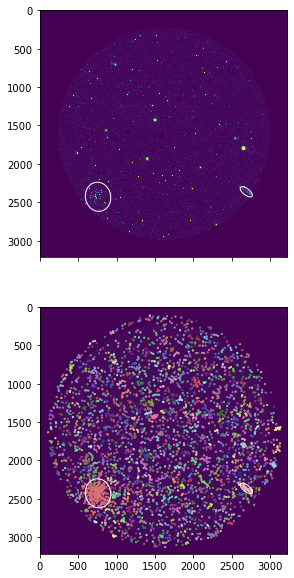

In [44]:
# ellipses for DBSC group

fig, axs = plt.subplots(2, 1,  figsize = (8, 10), sharex=True, sharey=True)

axs[0].imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')

for i in range(len(extended_sources_dbsc)):
    ell_patch = Ellipse((extended_sources_dbsc.loc[i,'xc'], extended_sources_dbsc.loc[i,'yc']), 2*extended_sources_dbsc.loc[i,'a'], 2*extended_sources_dbsc.loc[i,'b'], extended_sources_dbsc.loc[i,'theta']*180/np.pi, edgecolor='white', facecolor='none')
    axs[0].add_patch(ell_patch)
    
axs[1].imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
cmap = make_random_cmap(ncolors=4000,seed=34)

for i, group in enumerate(dbsc_star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CircularAperture(xypos, r=fwhm)
    ap.plot(color=cmap.colors[i],lw=.8)
    
for i in range(len(extended_sources_dbsc)):
    ell_patch = Ellipse((extended_sources_dbsc.loc[i,'xc'], extended_sources_dbsc.loc[i,'yc']), 2*extended_sources_dbsc.loc[i,'a'], 2*extended_sources_dbsc.loc[i,'b'], extended_sources_dbsc.loc[i,'theta']*180/np.pi, edgecolor='white', facecolor='none')
    axs[1].add_patch(ell_patch)
    
plt.show()